In [0]:
# Fill in your name using the format below and student ID number
your_name = "Scholtens, Tim"
student_id = "1028091"

In [0]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = False

In [6]:
# Uncomment the following line to run in Google Colab
!pip install --quiet openml 

     |████████████████████████████████| 163kB 3.4MB/s 


In [21]:
# Uncomment the following line to run in Google Colab
%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import gzip



from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout

In [23]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Tim, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [0]:
base_dir = '/content/drive/My Drive/Web information retrieval and data mining/Exercises/Assignment 3/' # For Google Colab
# base_dir = './'

In [25]:
#Uncomment to link Colab notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [0]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
oml.config.cache_directory = os.path.expanduser('/content/cache')

In [0]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [0]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255
yr = to_categorical(y)

In [0]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

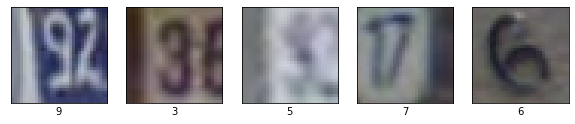

In [16]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [0]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')



def load_model_from_file(base_dir, name, extension='.h5'):
  """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
  function following the Keras API. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  try:
    # if a json description is available, load config and then weights
    if os.path.isfile(os.path.join(base_dir, name+'.json')):
      json_file = open(os.path.join(base_dir, name+'.json'), 'r')
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json)
      model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
    else:
      model = load_model(os.path.join(base_dir, name+extension))
  except OSError:
    shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
    return False
  return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
  """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  path = os.path.join(base_dir, name+extension)
  model.save(path)
  size = os.path.getsize(path)
  # If model > 100MB, store the weights and architecture only.
  if size > 100*1024*1024:
    print("Model larger than 100MB, storing weights only.")
    model.save_weights(path)
    model_json = model.to_json()
    with open(os.path.join(base_dir, name+".json"), "w") as json_file:
        json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
        return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
        return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

In [29]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(3072, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


answer_q_1_1 = """
# of nodes
- input 3x1024
- hidden layers(1024,512,256)(I had best performance),
- output 10 (10 labels)

activation functions
- relu: tanh had worse accuracy
- softmax: classification 

loss function:
- categorical_crossentropy: multi-classification loss

Batch size: 512, lower accuracy with smaller values (tested with < 124)

Optimizer: Adam, also tried rmsprop but seems stuck at another local minima.


"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

Answer is 410 characters long


Training the model
Epoch 1/50
125/125 [==============================] - 1s 12ms/step - loss: 2.4024 - accuracy: 0.1784 - val_loss: 2.2289 - val_accuracy: 0.1910
Epoch 2/50
125/125 [==============================] - 1s 11ms/step - loss: 2.1502 - accuracy: 0.2150 - val_loss: 1.9914 - val_accuracy: 0.2872
Epoch 3/50
125/125 [==============================] - 1s 11ms/step - loss: 1.7392 - accuracy: 0.3901 - val_loss: 1.6352 - val_accuracy: 0.4322
Epoch 4/50
125/125 [==============================] - 1s 11ms/step - loss: 1.4014 - accuracy: 0.5318 - val_loss: 1.3072 - val_accuracy: 0.5760
Epoch 5/50
125/125 [==============================] - 1s 11ms/step - loss: 1.1929 - accuracy: 0.6149 - val_loss: 1.1744 - val_accuracy: 0.6335
Epoch 6/50
125/125 [==============================] - 1s 11ms/step - loss: 1.0710 - accuracy: 0.6622 - val_loss: 1.0746 - val_accuracy: 0.6696
Epoch 7/50
125/125 [==============================] - 1s 11ms/step - loss: 0.9709 - accuracy: 0.6972 - val_loss: 1.1197 - v

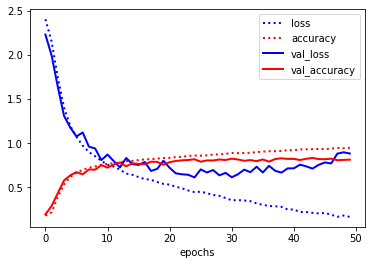

In [30]:
# %%time
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=512)

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [32]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val


# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

answer_q_1_2 = """
The data is pre-processed to be in greyscale. The model now needs
a different input dimensions (3x 1024 -> 1x 1024). 
The model can be trained faster (43 seconds as oppossed to 83.) 
which can be explained by the input layer now only has 1024 artificial neurons. 
Also the model seems to overfit less since the validation accuracy is slightly higher,
further testing is required.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

Answer is 381 characters long


Training the model
Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 2.2325 - accuracy: 0.1958 - val_loss: 2.0927 - val_accuracy: 0.2610
Epoch 2/50
125/125 [==============================] - 1s 4ms/step - loss: 1.7928 - accuracy: 0.3779 - val_loss: 1.5024 - val_accuracy: 0.5092
Epoch 3/50
125/125 [==============================] - 1s 4ms/step - loss: 1.3031 - accuracy: 0.5808 - val_loss: 1.2638 - val_accuracy: 0.6039
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 1.1033 - accuracy: 0.6551 - val_loss: 1.1644 - val_accuracy: 0.6395
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.9924 - accuracy: 0.6961 - val_loss: 1.0054 - val_accuracy: 0.6986
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.9116 - accuracy: 0.7219 - val_loss: 0.9494 - val_accuracy: 0.7013
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.8531 - accuracy: 0.7400 - val_loss: 0.8545 - val_accu

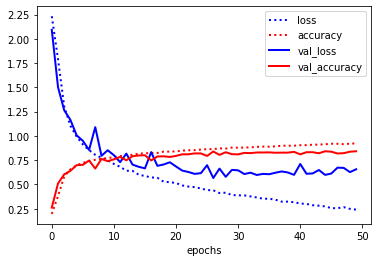

In [33]:
# %%time

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=512)


### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

In [0]:
def build_model_1_3(dropout_rate, learning_rate, optimizer):
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu')) 
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# create model
# clf = KerasClassifier(build_model_1_3, epochs=20, verbose=False)


# define the grid search parameters
param_grid = {
              'batch_size': [512, 256, 128],
              'optimizer' : [Adam],
              'dropout_rate': [0, 0.1, 0.25, 0.5],
              'learning_rate' : [1e-3, 5e-3, 1e-4],
}
 
# Use validation data set as input for cv parameter, as we are trying to reduce overfitting
# grid = GridSearchCV(clf, param_grid=param_grid, cv=3, return_train_score=True) 
# grid.fit(rgb2gray(X_train), y_train)

# summarize results
# res = pd.DataFrame(grid.cv_results_)


# res.pivot_table(index=["param_batch_size", "param_optimizer", "param_dropout_rate", "param_learning_rate"],
#                 values=['mean_train_score', "mean_test_score"])


mean_test_score  mean_train_score
param_batch_size param_optimizer                                    param_dropout_rate param_learning_rate                                   
128              <class 'tensorflow.python.keras.optimizer_v2.ad... 0.00               0.0001                      0.834776          0.947052
                                                                                       0.0010                      0.830590          0.943165
                                                                                       0.0050                      0.820990          0.867619
                                                                    0.10               0.0001                      0.842345          0.934376
                                                                                       0.0010                      0.829362          0.937618
                                                                                       0.0050                      0.811642          0.851890
                                                                    0.25               0.0001                      0.845918          0.918316
                                                                                       0.0010                      0.835972          0.934384
                                                                                       0.0050                      0.801224          0.835563
                                                                    0.50               0.0001                      0.836837          0.882971
                                                                                       0.0010                      0.830212          0.897921
                                                                                       0.0050                      0.769293          0.792427
256              <class 'tensorflow.python.keras.optimizer_v2.ad... 0.00               0.0001                      0.832384          0.935218
                                                                                       0.0010                      0.835217          0.950294
                                                                                       0.0050                      0.816505          0.866864
                                                                    0.10               0.0001                      0.838537          0.923439
                                                                                       0.0010                      0.834131          0.944574
                                                                                       0.0050                      0.812807          0.853299
                                                                    0.25               0.0001                      0.840835          0.906380
                                                                                       0.0010                      0.831534          0.934652
                                                                                       0.0050                      0.808385          0.841763
                                                                    0.50               0.0001                      0.832824          0.874567
                                                                                       0.0010                      0.835516          0.909850
                                                                                       0.0050                      0.786652          0.810651
512              <class 'tensorflow.python.keras.optimizer_v2.ad... 0.00               0.0001                      0.827914          0.918993
                                                                                       0.0010                      0.831613          0.950381
                                                                                       0.0050                      0.821966         

Training the model
Epoch 1/50
993/993 [==============================] - 6s 6ms/step - loss: 1.2900 - accuracy: 0.5936 - val_loss: 0.8859 - val_accuracy: 0.7364
Epoch 2/50
993/993 [==============================] - 6s 6ms/step - loss: 0.8551 - accuracy: 0.7416 - val_loss: 0.7573 - val_accuracy: 0.7780
Epoch 3/50
993/993 [==============================] - 6s 6ms/step - loss: 0.7312 - accuracy: 0.7823 - val_loss: 0.6683 - val_accuracy: 0.8036
Epoch 4/50
993/993 [==============================] - 6s 6ms/step - loss: 0.6641 - accuracy: 0.8018 - val_loss: 0.6489 - val_accuracy: 0.8093
Epoch 5/50
993/993 [==============================] - 6s 6ms/step - loss: 0.6115 - accuracy: 0.8160 - val_loss: 0.5995 - val_accuracy: 0.8281
Epoch 6/50
993/993 [==============================] - 6s 6ms/step - loss: 0.5739 - accuracy: 0.8272 - val_loss: 0.5965 - val_accuracy: 0.8306
Epoch 7/50
993/993 [==============================] - 6s 6ms/step - loss: 0.5424 - accuracy: 0.8359 - val_loss: 0.5728 - val_accu

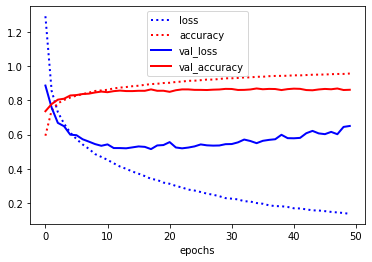

In [0]:
# hashtag trump
def build_THE_best_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(Dropout(0.10))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model   

run_evaluation("model_1_3",build_THE_best_model_1_3 , preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)
answer_q_1_3 = """
To reduce overfitting, several techniques have been used:
- Batch normalization: normalize each batch.
- Drop out: randomly leave out outputs from neurons.

Furthermore gridsearchCV is used for discovering the best parameters for 
learning rate, batch size and drop out. 

    """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

In [0]:
def build_model_2_1(convolutional_filter, max_pooling_filter, learning_rate, optimizer):

    model = models.Sequential()
    model.add(layers.Conv2D(32, convolutional_filter, activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(max_pooling_filter))
    model.add(layers.Conv2D(64, convolutional_filter, activation='relu'))
    model.add(layers.MaxPooling2D(max_pooling_filter))
    model.add(layers.Conv2D(64, convolutional_filter, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  
    return model
    

# create model
clf = KerasClassifier(build_model_2_1, epochs=20, verbose=False)


# define the grid search parameters
param_grid = {
              'batch_size':             [512, 256, 128, 64],
              'optimizer' :             [Adam],
              'learning_rate' :         [1e-3, 5e-3, 1e-4],
              'convolutional_filter' :  [(3,3), (2,2)],
              'max_pooling_filter':     [(2,2), (1,1)]
}
 
# Use validation data set as input for cv parameter, as we are trying to reduce overfitting
# grid = GridSearchCV(clf, param_grid=param_grid, cv=3, return_train_score=True) 
# grid.fit(rgb2gray(X_train), y_train)

# summarize results
# res = pd.DataFrame(grid.cv_results_)


# res.pivot_table(index=["param_batch_size", "param_optimizer", "param_learning_rate", "param_convolutional_filter", "param_max_pooling_filter"],
#                 values=['mean_train_score', "mean_test_score"])


mean_test_score  mean_train_score
param_batch_size param_optimizer                                    param_learning_rate param_convolutional_filter param_max_pooling_filter                                   
64               <class 'tensorflow.python.keras.optimizer_v2.ad... 0.0001              (2, 2)                     (1, 1)                           0.845383          0.993115
                                                                                                                   (2, 2)                           0.887574          0.938248
                                                                                        (3, 3)                     (1, 1)                           0.872199          0.995908
                                                                                                                   (2, 2)                           0.898102          0.944125
                                                                    0.0010              (2, 2)                     (1, 1)                           0.826719          0.970351
                                                                                                                   (2, 2)                           0.873741          0.966582
                                                                                        (3, 3)                     (1, 1)                           0.850875          0.977535
                                                                                                                   (2, 2)                           0.893963          0.981202
                                                                    0.0050              (2, 2)                     (1, 1)                           0.522062          0.592771
                                                                                                                   (2, 2)                           0.846185          0.874670
                                                                                        (3, 3)                     (1, 1)                           0.190954          0.190954
                                                                                                                   (2, 2)                           0.864551          0.903885
128              <class 'tensorflow.python.keras.optimizer_v2.ad... 0.0001              (2, 2)                     (1, 1)                           0.839780          0.984019
                                                                                                                   (2, 2)                           0.882271          0.918859
                                                                                        (3, 3)                     (1, 1)                           0.868123          0.991589
                                                                                                                   (2, 2)                           0.890029          0.925382
                                                                    0.0010              (2, 2)                     (1, 1)                           0.824373          0.968321
                                                                                                                   (2, 2)                           0.874528          0.968313
                                                                                        (3, 3)                     (1, 1)                           0.844580          0.972428
                                                                                                                   (2, 2)                           0.892342          0.973192
                                                                    0.0050              (2, 2)                     (1, 1)                           0.535612          0.611986
                                                                                                                   (

Training the model
Epoch 1/50
993/993 [==============================] - 4s 4ms/step - loss: 1.2160 - accuracy: 0.6202 - val_loss: 0.6895 - val_accuracy: 0.8082
Epoch 2/50
993/993 [==============================] - 4s 4ms/step - loss: 0.6110 - accuracy: 0.8293 - val_loss: 0.5655 - val_accuracy: 0.8427
Epoch 3/50
993/993 [==============================] - 4s 4ms/step - loss: 0.5167 - accuracy: 0.8556 - val_loss: 0.5140 - val_accuracy: 0.8514
Epoch 4/50
993/993 [==============================] - 4s 4ms/step - loss: 0.4635 - accuracy: 0.8696 - val_loss: 0.4680 - val_accuracy: 0.8661
Epoch 5/50
993/993 [==============================] - 4s 4ms/step - loss: 0.4238 - accuracy: 0.8800 - val_loss: 0.4346 - val_accuracy: 0.8767
Epoch 6/50
993/993 [==============================] - 4s 4ms/step - loss: 0.3927 - accuracy: 0.8880 - val_loss: 0.4108 - val_accuracy: 0.8832
Epoch 7/50
993/993 [==============================] - 4s 4ms/step - loss: 0.3669 - accuracy: 0.8969 - val_loss: 0.4034 - val_accu

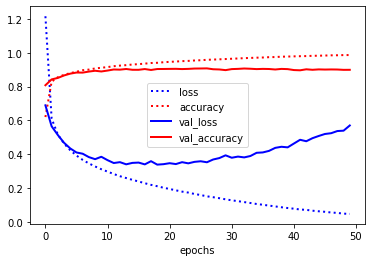

In [0]:
def build_model_2_1():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  
    return model


run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)
answer_q_2_1 = """
Reduce overfitting
- Max pooling
- Batch normalization

Compatability
- Flatten layer
- Dense layer of 10 neurons for 10 labels

Parameters
For choosing the values of the parameters I've made use of gridsearchCV again:
- Convolutional filter (3,3)
- Max Pooling filter (2,2)
- Batch size 64
- Learning rate 0.0001

               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [0]:
# Use ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest'
    # horizontal_flip=True,
)


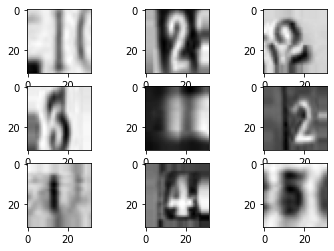

In [0]:
### Cell used for experimenting with above ImageGenerator functions
from matplotlib import pyplot

for X_batch, y_batch in train_datagen.flow(rgb2gray(X_train), y_train, batch_size=9):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(32,32), cmap='gray')
	
    # show the plot
    pyplot.show()
    break

Training the model
Epoch 1/50
60/60 [==============================] - 1s 18ms/step - loss: 2.2448 - accuracy: 0.1875 - val_loss: 2.2883 - val_accuracy: 0.2089
Epoch 2/50
60/60 [==============================] - 1s 16ms/step - loss: 2.1522 - accuracy: 0.2417 - val_loss: 2.2686 - val_accuracy: 0.1948
Epoch 3/50
60/60 [==============================] - 1s 17ms/step - loss: 2.0453 - accuracy: 0.2953 - val_loss: 2.2388 - val_accuracy: 0.2570
Epoch 4/50
60/60 [==============================] - 1s 17ms/step - loss: 1.8953 - accuracy: 0.3823 - val_loss: 2.1747 - val_accuracy: 0.3895
Epoch 5/50
60/60 [==============================] - 1s 17ms/step - loss: 1.7303 - accuracy: 0.4526 - val_loss: 2.0615 - val_accuracy: 0.3618
Epoch 6/50
60/60 [==============================] - 1s 16ms/step - loss: 1.5369 - accuracy: 0.5063 - val_loss: 1.9184 - val_accuracy: 0.4529
Epoch 7/50
60/60 [==============================] - 1s 17ms/step - loss: 1.3512 - accuracy: 0.5802 - val_loss: 1.7035 - val_accuracy: 0

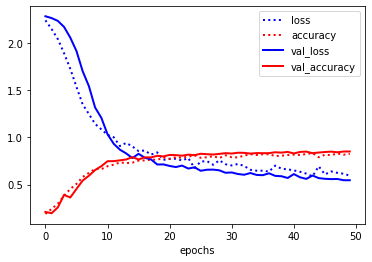

In [0]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
augmented_split =  train_datagen.flow(rgb2gray(X_train), y_train, batch_size=32), rgb2gray(X_val), y_val

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, epochs=50, batch_size=64, generator=True)


In [0]:
answer_q_2_2 = """
Surrounding the label of interest there is noise and sometimes an other label
is within sight, to reduce this I've zoomed in onto the image.

My observation is that the model is less accurate than the model 
trained on the non augmented data - 98.7% vs 83.3%.  However the previous model 
seems to over fit, as there is a gap of -8% with the validation data set.
This model's validation accuracy is higher than the accuracy of the training data.

Lastly,  this model has a significantly lower training time.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

Answer is 509 characters long


## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [0]:
model_2_2 = load_model_from_file(base_dir,'model_2_2')

In [0]:
y_pred = model_2_2.predict(rgb2gray(X_test))
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

print(f'{1 - (len(misclassified_samples)/len(y_pred))}')
test_accuracy_3_1 = 1 - (len(misclassified_samples)/len(y_pred))

0.847064155504079


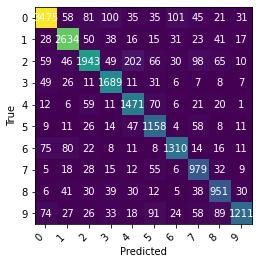

In [0]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix():
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(y_test, axis=1))
    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10), rotation=45, ha="right")
    ax.set_yticklabels(np.arange(10))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

plot_confusion_matrix()

Answer is 389 characters long


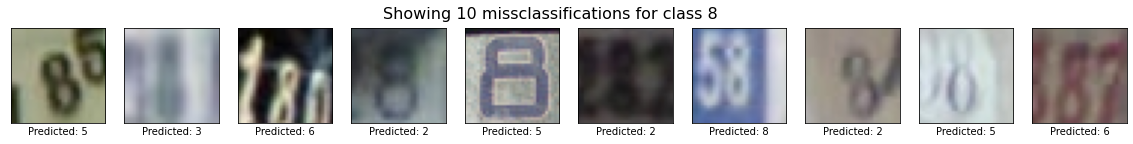

In [0]:
from random import randint


# For a given class show predicted image vs actual image, interpret this. 
class_under_investigation = 8
number_of_images_to_show  = 10

def plot_misclassifications():


    class_under_investigation_ix        = set(np.nonzero(np.argmax(y_test, axis=1) == (class_under_investigation - 1))[0]) # label is index + 1
    missclassified_images_ix            = set(np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0])
    missclassified_images_for_class_ix  = class_under_investigation_ix.intersection(missclassified_images_ix)


    fig, axes = plt.subplots(1,number_of_images_to_show,  figsize=(number_of_images_to_show * 2, 2))
    fig.suptitle(f'Showing {number_of_images_to_show} missclassifications for class {class_under_investigation}', fontsize=16)


    for i, image_ix in enumerate(missclassified_images_for_class_ix):

        axes[i].imshow(X_test[image_ix].reshape(32,32,3), cmap='gray')
        axes[i].set_xlabel(f"Predicted: {np.argmax(y_pred[image_ix])}")
        axes[i].set_xticks(()), axes[i].set_yticks(())


        if i == (number_of_images_to_show - 1):
            break


plot_misclassifications()




answer_q_3_1 = """
               From the confusion matrix can be observed that class '8' is misclassified quite often. 
               In the images multiple factors of noise can be spotted:
                    - The brightness (the 6th image is very dark while the 9th is bright)
                    - Depicting multiple numbers in the same image
                    - 2nd image is blurry
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [0]:
import math

model_2_2 = load_model_from_file(base_dir,'model_2_2')


# Toying around with first layer

# print(model_2_2.layers[0])
print(model_2_2.summary())

# print('input image')
# plt.imshow(rgb2gray(np.expand_dims(X_test[0], axis=0)).reshape(32,32))


def show_layer_filters(layer_index, number_of_filters, model=model_2_2):

    first_conv2d_layer_output = model.layers[layer_index].output
    activation_model = models.Model(inputs=model.input, outputs=first_conv2d_layer_output)

    activations = activation_model.predict(rgb2gray(np.expand_dims(X_test[0], axis=0)))

    
    images_per_row    = 4
    fig, ax = plt.subplots(ncols=images_per_row,
                           nrows=math.ceil((number_of_filters // images_per_row)),
                            figsize=(20,15))

    fig.suptitle(f'Feature map of layer {layer_index}', fontsize=16)


    for i in range(number_of_filters):        
        
        row = math.floor(i / images_per_row)
        col = i % images_per_row

        # print(f'row: {row} , col: {col}')
        ax[row,col].matshow(activations[0, :, :, i], cmap='viridis')
        ax[row,col].set_xlabel(f'Activation of filter {i + 1}');
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())




# Output of first conv2d layer
# show_layer_filters(0)




Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_480 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_155 (Bat (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_320 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_481 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_321 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_482 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_160 (Flatten)        (None, 1024)           

Answer is 282 characters long


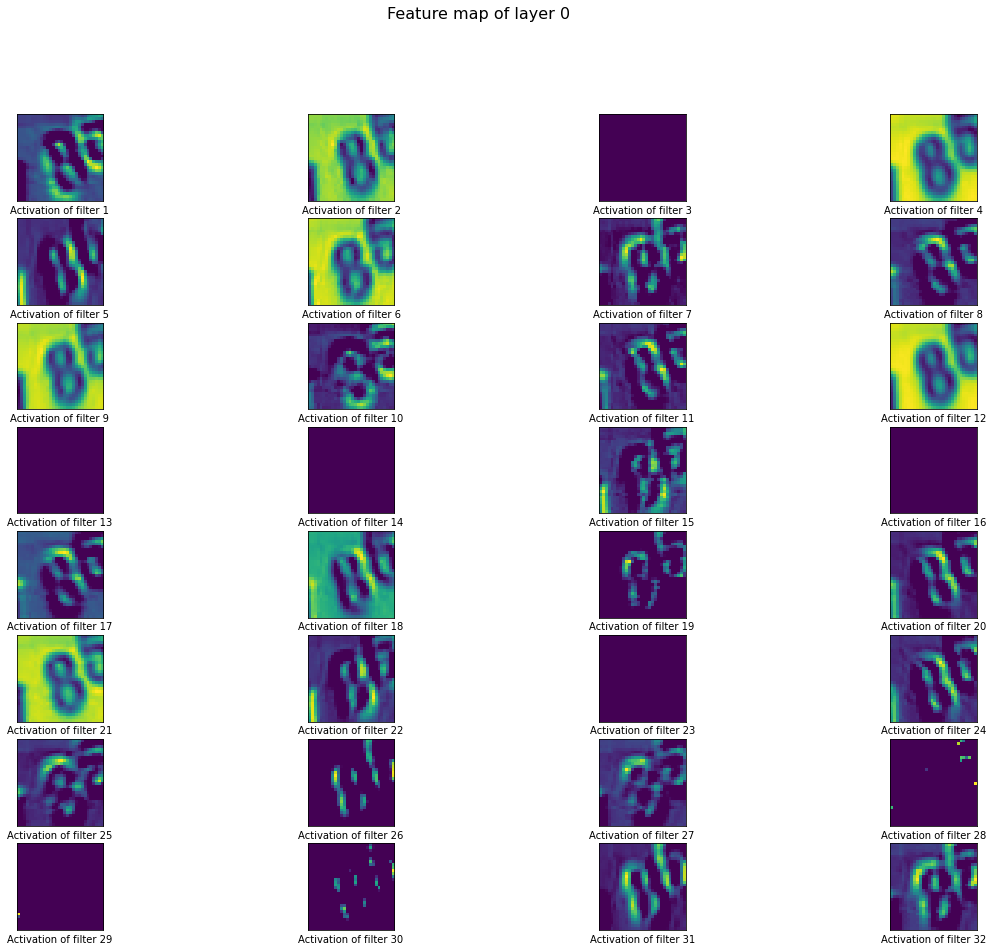

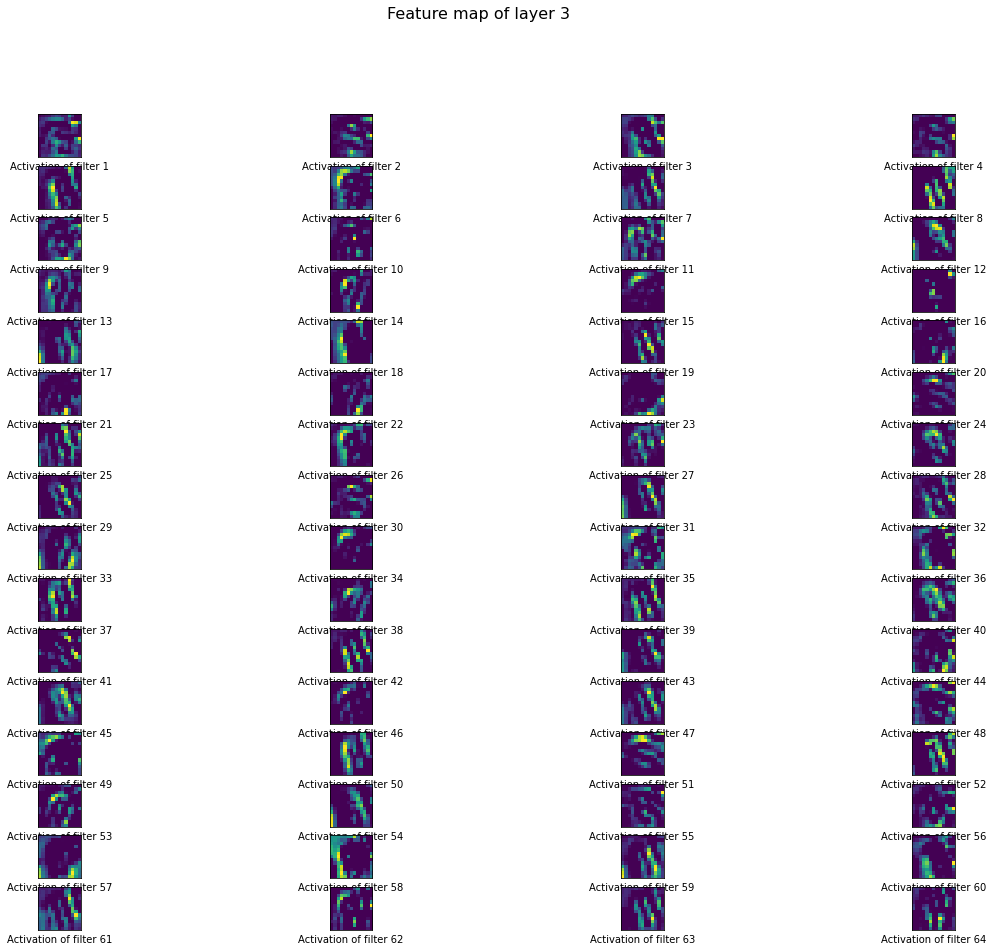

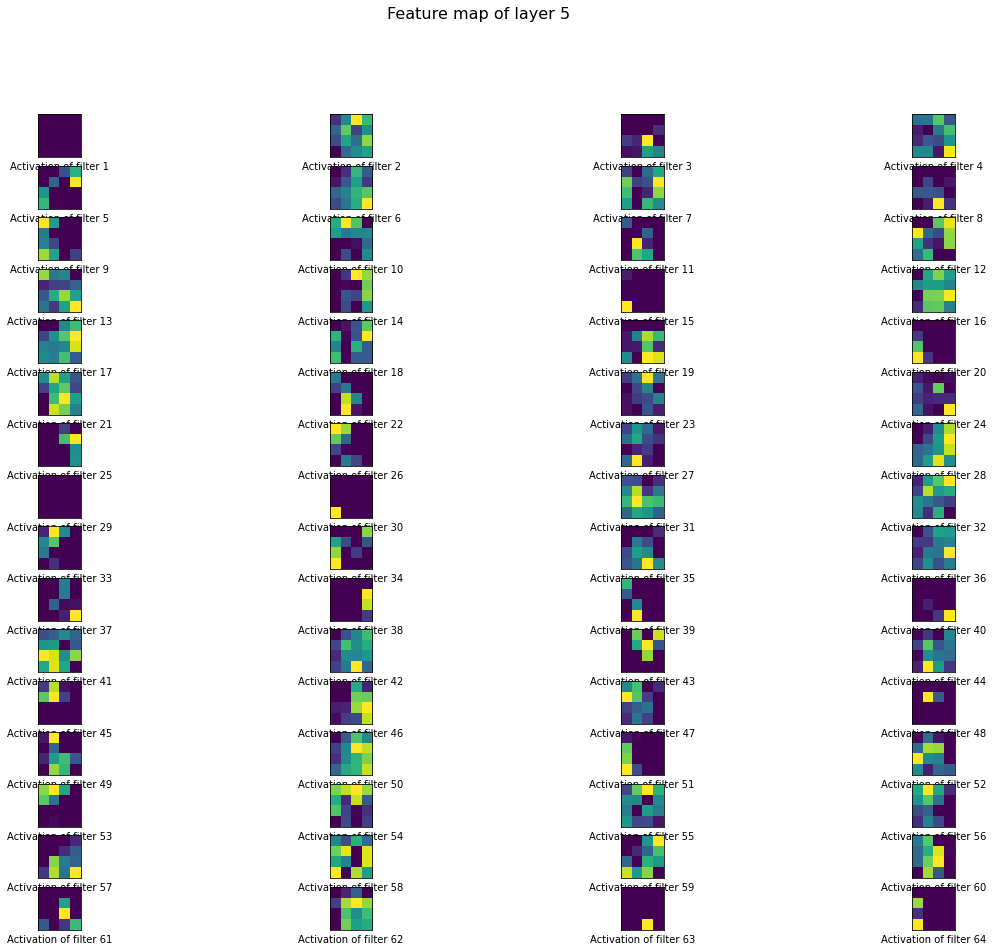

In [0]:
def plot_activations():

    # Show input image
    input_image_grey = rgb2gray(np.expand_dims(X_test[0], axis=0))
    # print(np.argmax(y_test[0]) + 1) # Label is index+1
    # plt.imshow(input_image_grey.reshape(32,32))


    # Show all filters for conv2d layers
    show_layer_filters(0, number_of_filters=32)
    show_layer_filters(3, number_of_filters=64)
    show_layer_filters(5, number_of_filters=64)


plot_activations()

answer_q_3_2 = """
In the feature maps of layers 0 and 3 I see that the edges of label '8' are used as filter. 
Also I see that some edges of other labels are being learned (if present), which isn't a good thing.
For the final feature map (layer 5), I can't observe any filter which might be of use.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

In [0]:
def plot_3_3():
  pass

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [34]:
vgg_16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet', classes=10) # include_top=False to not include dense layers
# vgg_16_model.summary()

def build_model_4_1():

    model = models.Sequential()
    model.add(vgg_16_model)        
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # Set vgg_16 model to non_trainable
    model.layers[0].trainable = False

    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# build_model_4_1().summary()
# build_model_4_1().fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

58892288/58889256 [==============================] - 1s 0us/step


Training the model
Epoch 1/10
993/993 [==============================] - 11s 11ms/step - loss: 1.5094 - accuracy: 0.4807 - val_loss: 1.3930 - val_accuracy: 0.5205
Epoch 2/10
993/993 [==============================] - 11s 11ms/step - loss: 1.3246 - accuracy: 0.5471 - val_loss: 1.3173 - val_accuracy: 0.5458
Epoch 3/10
993/993 [==============================] - 11s 11ms/step - loss: 1.2531 - accuracy: 0.5695 - val_loss: 1.2836 - val_accuracy: 0.5591
Epoch 4/10
993/993 [==============================] - 11s 11ms/step - loss: 1.2023 - accuracy: 0.5879 - val_loss: 1.2367 - val_accuracy: 0.5754
Epoch 5/10
993/993 [==============================] - 11s 11ms/step - loss: 1.1629 - accuracy: 0.6017 - val_loss: 1.2267 - val_accuracy: 0.5794
Epoch 6/10
993/993 [==============================] - 11s 11ms/step - loss: 1.1270 - accuracy: 0.6137 - val_loss: 1.1970 - val_accuracy: 0.5896
Epoch 7/10
993/993 [==============================] - 11s 11ms/step - loss: 1.0957 - accuracy: 0.6254 - val_loss: 1.2

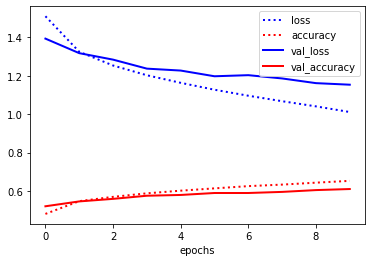

In [35]:
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=64)
answer_q_4_1 = """
               Your answer 
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [0]:


vgg_16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet', classes=10)


def store_embedding(X, name):  

    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)


def store_embeddings():
    """ Stores all necessary embeddings to file
    """

    # Create VGG-16 model without dense layers
    def VGG16_wo_dense():

        model = models.Sequential()
        model.add(vgg_16_model)        

        # Set vgg_16 model to non_trainable
        model.layers[0].trainable = False

        
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        return model

    model = VGG16_wo_dense()

    X_train_embeddings = np.array([model.predict(np.expand_dims(image, axis=0)).reshape(512) for image in X_train])
    X_test_embeddings  = np.array([model.predict(np.expand_dims(image, axis=0)).reshape(512) for image in X_test])
    
    store_embedding(X=X_train_embeddings, name='x_train')
    store_embedding(X=X_test_embeddings, name='x_test')

store_embeddings()

In [0]:
def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def generate_pipeline():
  """ Returns an sklearn pipeline.
  """
  return make_pipeline(StandardScaler(), RandomForestClassifier())

In [0]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
        evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    clf = pipeline()
    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

    test_accuracy = 1 - (len(misclassified_samples)/len(y_pred))

    return test_accuracy

In [40]:
def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """


    test_accuracy = evaluate_pipeline(pipeline=generate_pipeline,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)
    
    return test_accuracy


X_train_embedding = load_embedding('x_train')
X_test_embedding  = load_embedding('x_test')

print(evaluation_4_2(X_train=X_train_embedding,
               y_train=y_train,
               X_test=X_test_embedding,
               y_test=y_test))



answer_q_4_2 = """
I get a pretty bad performance < 30% accuracy (on test set) when using randomforest classifier out of the box.
So no, I won't believe this model will be suitable for achieving higher than 85% accuracy(current best) on the <bold>test</bold> set.
               """
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

0.25198912277167895
Pipeline: Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_star

#Verify


In [0]:


# %cd drive/My Drive/Web information retrieval and data mining/Exercises/Assignment 3/
# !python3 '/content/drive/My Drive/Web information retrieval and data mining/Exercises/Assignment 3/verify.py


/content/drive/My Drive/Web information retrieval and data mining/Exercises/Assignment 3
